<a href="https://colab.research.google.com/github/Ushnish-Sengupta/FYR/blob/master/keras_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Anchored Ensembling for Predicting Decay Rates and Operating Conditions
=========

This notebook shows how Bayesian NN ensembles can be implemented for predicting decay rates in our combustor. We use a two-layer fully connected NN.




In [5]:
!pip install -e git+https://github.com/marcoancona/DeepExplain.git#egg=deepexplain

Obtaining deepexplain from git+https://github.com/marcoancona/DeepExplain.git#egg=deepexplain
  Cloning https://github.com/marcoancona/DeepExplain.git to ./src/deepexplain
  Running command git clone -q https://github.com/marcoancona/DeepExplain.git /content/src/deepexplain
  Running setup.py develop for deepexplain


In [2]:
%matplotlib inline
%tensorflow_version 1.x
from math import pi
import keras
import gdown
from keras import backend as K
from keras.layers import Dense
from keras.models import Sequential, Model
from keras.layers.advanced_activations import PReLU
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os.path
from scipy.io import loadmat
from deepexplain.tensorflow import DeepExplain

Using TensorFlow backend.


In [11]:
!wget -O All_Data.mat "https://onedrive.live.com/download?cid=CF171CC1F54CF4B5&resid=CF171CC1F54CF4B5%213659&authkey=AEWFKoBhIracOYs"

--2019-12-04 15:39:14--  https://onedrive.live.com/download?cid=CF171CC1F54CF4B5&resid=CF171CC1F54CF4B5%213659&authkey=AEWFKoBhIracOYs
Resolving onedrive.live.com (onedrive.live.com)... 13.107.42.13
Connecting to onedrive.live.com (onedrive.live.com)|13.107.42.13|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://xlm0dw.db.files.1drv.com/y4miAXaSxkwVvH-1vNZibibpXmhrEZazmn-xHnclT9ieyDuiDMa8UvpVFYkGGTUZ1eDEY9_sLQUAhG52CjQuzE3ka9LYQZjG16e3Q2FrpRYk8EPkHWqwQ6hVnT6oWdUDKVXZFS7f-l8wHiSf8kRUkPs-JOMUlzZIn8V12Zc_gRV0dpzHI-bXqTwoROyxo_YVLJwi6ok2CYEI4DVMgl3h3DPGg/All_Data.mat?download&psid=1 [following]
--2019-12-04 15:39:15--  https://xlm0dw.db.files.1drv.com/y4miAXaSxkwVvH-1vNZibibpXmhrEZazmn-xHnclT9ieyDuiDMa8UvpVFYkGGTUZ1eDEY9_sLQUAhG52CjQuzE3ka9LYQZjG16e3Q2FrpRYk8EPkHWqwQ6hVnT6oWdUDKVXZFS7f-l8wHiSf8kRUkPs-JOMUlzZIn8V12Zc_gRV0dpzHI-bXqTwoROyxo_YVLJwi6ok2CYEI4DVMgl3h3DPGg/All_Data.mat?download&psid=1
Resolving xlm0dw.db.files.1drv.com (xlm0dw.db.files.1drv.com

We import the .mat files containing the combustion noise spectrum data.

In [0]:
output_q = 'eq' #output_q can take the following values -- 'decay', 'eq', 'power'
train_x = loadmat('All_Data.mat')['input_data_train']
test_x = loadmat('All_Data.mat')['input_data_test']
train_y = np.squeeze(loadmat('All_Data.mat')[output_q + '_train'])
test_y = np.squeeze(loadmat('All_Data.mat')[output_q + '_test'])

In [0]:
#Do minmax scaling
min_x = train_x.min(0)
max_x = train_x.max(0)
train_x = 2*(train_x - min_x)/(max_x - min_x) - 1
test_x = 2*(test_x - min_x)/(max_x - min_x) - 1
#Do minmax scaling
min_decaytime = train_y.min(0)
max_decaytime = train_y.max(0)
train_y = 2*(train_y - min_decaytime)/(max_decaytime - min_decaytime) - 1
test_y = 2*(test_y - min_decaytime)/(max_decaytime - min_decaytime) - 1
#columns of x and y are [-1,1] now

Inputs and outputs are scaled so that everything lies between [-1,1]. This helps the training of the networks and specification of a prior.

In [0]:
# NN options
n_ensemble = 10 # TUNE! no. NNs in ensemble
reg = 'anc'		# type of regularisation to use - anc (anchoring) reg (regularised) free (unconstrained)
n_hidden = 25 	# TUNE! no. hidden units in NN
activation_in = 'relu' #tanh relu sigmoid
data_noise = (0.03/((max_decaytime - min_decaytime)/2))**2 # TUNE! estimated noise variance

n_data = train_x.shape[0]
print(n_data)
n_dim = train_x.shape[-1]
print(n_dim)

# optimisation options
epochs = 64 		# run reg for 15+ epochs seems to mess them up
l_rate = 0.00025 		# learning rate

# variance of priors
W1_var = 1.0/n_dim		# TUNE! 1st layer weights and biases
W_mid_var = 1.0/n_hidden	# 2nd layer weights and biases
W_last_var = 1.0/n_hidden	# 3rd layer weights

20820
1501


In [0]:
# NN object
def fn_make_NN(reg='anc', activation_in='relu'):

	#act = keras.layers.advanced_activations.PReLU(init='zero', weights=None)

	# get initialisations, and regularisation values
	W1_lambda = data_noise/W1_var
	W1_anc = np.random.normal(loc=0,scale=np.sqrt(W1_var),size=[n_dim, n_hidden])
	W1_init = np.random.normal(loc=0,scale=np.sqrt(W1_var),size=[n_dim, n_hidden])

	b1_var = W1_var*n_dim
	b1_lambda =  data_noise/b1_var
	b1_anc = np.random.normal(loc=0,scale=np.sqrt(b1_var),size=[n_hidden])
	b1_init = np.random.normal(loc=0,scale=np.sqrt(b1_var),size=[n_hidden])

	W_mid_lambda = data_noise/W_mid_var
	W_mid_anc = np.random.normal(loc=0,scale=np.sqrt(W_mid_var),size=[n_hidden,n_hidden])
	W_mid_init = np.random.normal(loc=0,scale=np.sqrt(W_mid_var),size=[n_hidden,n_hidden])

	b_mid_var = W_mid_var
	b_mid_lambda =  data_noise/b_mid_var
	b_mid_anc = np.random.normal(loc=0,scale=np.sqrt(b_mid_var),size=[n_hidden])
	b_mid_init = np.random.normal(loc=0,scale=np.sqrt(b_mid_var),size=[n_hidden])
    
	W_last_lambda = data_noise/W_last_var
	W_last_anc = np.random.normal(loc=0,scale=np.sqrt(W_last_var),size=[n_hidden, 1])
	W_last_init = np.random.normal(loc=0,scale=np.sqrt(W_last_var),size=[n_hidden, 1])

	# create custom regularised
	def custom_reg_W1(weight_matrix):
		if reg == 'reg':
			return K.sum(K.square(weight_matrix)) * W1_lambda/n_data
		elif reg == 'free':
			return 0.
		elif reg == 'anc':
			return K.sum(K.square(weight_matrix - W1_anc)) * W1_lambda/n_data

	def custom_reg_b1(weight_matrix):
		if reg == 'reg':
			return K.sum(K.square(weight_matrix)) * b1_lambda/n_data
		elif reg == 'free':
			return 0.
		elif reg == 'anc':
			return K.sum(K.square(weight_matrix - b1_anc)) * b1_lambda/n_data

	def custom_reg_W_mid(weight_matrix):
		if reg == 'reg':
			return K.sum(K.square(weight_matrix)) * W_mid_lambda/n_data
		elif reg == 'free':
			return 0.
		elif reg == 'anc':
			return K.sum(K.square(weight_matrix - W_mid_anc)) * W_mid_lambda/n_data

	def custom_reg_b_mid(weight_matrix):
		if reg == 'reg':
			return K.sum(K.square(weight_matrix)) * b_mid_lambda/n_data
		elif reg == 'free':
			return 0.
		elif reg == 'anc':
			return K.sum(K.square(weight_matrix - b_mid_anc)) * b_mid_lambda/n_data

	def custom_reg_W_last(weight_matrix):
		if reg == 'reg':
			return K.sum(K.square(weight_matrix)) * W_last_lambda/n_data
		elif reg == 'free':
			return 0.
		elif reg == 'anc':
			return K.sum(K.square(weight_matrix - W_last_anc)) * W_last_lambda/n_data

	model = Sequential()
	model.add(Dense(n_hidden, activation=activation_in, input_shape=(n_dim,),
		kernel_initializer=keras.initializers.Constant(value=W1_init),
		bias_initializer=keras.initializers.Constant(value=b1_init),
		kernel_regularizer=custom_reg_W1,
		bias_regularizer=custom_reg_b1))

	model.add(Dense(n_hidden, activation=activation_in,
		kernel_initializer=keras.initializers.Constant(value=W_mid_init),
		bias_initializer=keras.initializers.Constant(value=b_mid_init),
		kernel_regularizer=custom_reg_W_mid,
		bias_regularizer=custom_reg_b_mid))

	model.add(Dense(1, activation='linear',use_bias=False,
		kernel_initializer=keras.initializers.Constant(value=W_last_init),
		kernel_regularizer=custom_reg_W_last))

	model.compile(loss='mean_squared_error', 
		optimizer=keras.optimizers.Adam(lr=l_rate), metrics=['mae'])

	return model


def fn_predict_ensemble(NNs, x_test):
	''' fn to predict given a list of NNs (an ensemble)''' 
	y_preds = []
	for m in range(len(NNs)):
		y_preds.append(NNs[m].predict(x_test, verbose=0))
	y_preds = np.array(y_preds)

	y_preds_mu = np.mean(y_preds,axis=0)
	y_preds_std = np.std(y_preds,axis=0)

	return y_preds, y_preds_mu, y_preds_std

In [0]:
# create the NNs
NNs=[]
for m in range(n_ensemble):
	NNs.append(fn_make_NN(reg=reg, activation_in=activation_in))
print(NNs[-1].summary())



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 25)                37550     
_________________________________________________________________
dense_29 (Dense)             (None, 25)                650       
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 25        
Total params: 38,225
Trainable params: 38,225
Non-trainable params: 0
_________________________________________________________________
None


How does our prior look like?

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  """


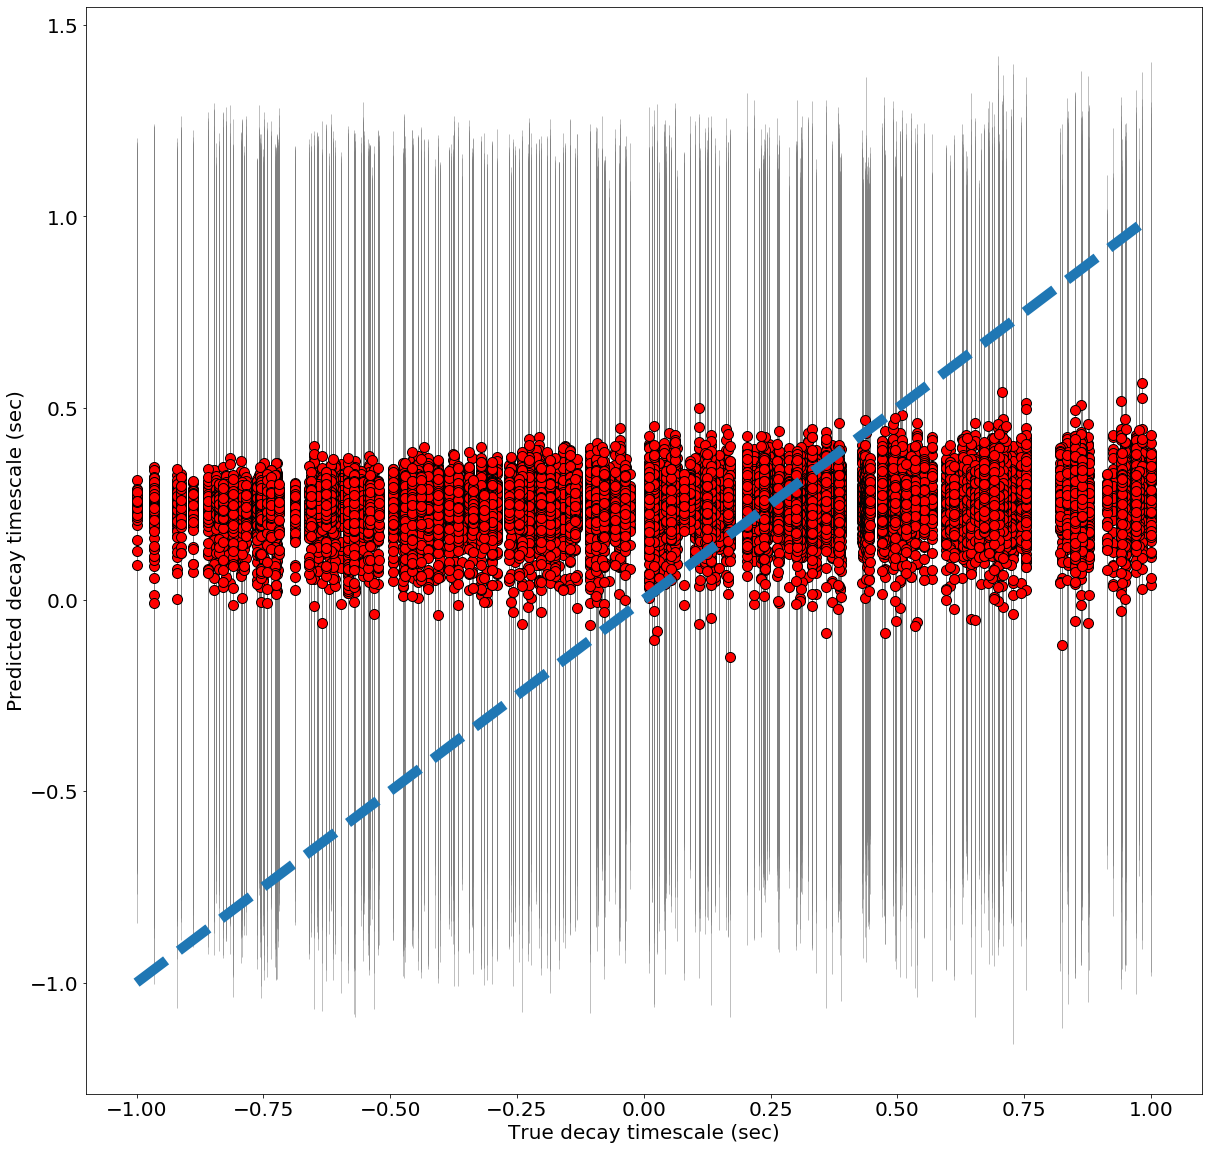

0.79975766


In [0]:
y_preds_train, y_preds_mu_train, y_preds_std_train = fn_predict_ensemble(NNs,train_x)
# plot predictions
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(20,20))
plt.errorbar(train_y, y_preds_mu_train, yerr=(y_preds_std_train*1),linewidth = 0.5, color = 'gray', ms=10,mfc='red',mec='black', fmt='o')
plt.plot(np.arange(np.min(train_y), np.max(train_y), 0.01), np.arange(np.min(train_y), np.max(train_y), 0.01), linewidth = 10, linestyle = 'dashed',zorder = 100)
plt.xlabel('True decay timescale (sec)')
plt.ylabel('Predicted decay timescale (sec)')
plt.show()
print(np.mean(y_preds_std_train))

Train the ensemble.

In [0]:
# do training
NNs_hist_train=[];
for m in range(n_ensemble):
	print('-- training: ' + str(m+1) + ' of ' + str(n_ensemble) + ' NNs --')
	hist = NNs[m].fit(train_x, train_y,
			  batch_size=32,
			  epochs=epochs,
			  verbose=1)
	NNs_hist_train.append(hist.history['loss'])

# make predictions
y_preds, y_preds_mu, y_preds_std = fn_predict_ensemble(NNs,test_x)

-- training: 1 of 10 NNs --


Epoch 1/64
20820/20820 [==============================] - 2s 105us/step - loss: 0.1599 - mean_absolute_error: 0.2094
Epoch 2/64
20820/20820 [==============================] - 2s 86us/step - loss: 0.1160 - mean_absolute_error: 0.1583
Epoch 3/64
20820/20820 [==============================] - 2s 86us/step - loss: 0.1028 - mean_absolute_error: 0.1472
Epoch 4/64
20820/20820 [==============================] - 2s 86us/step - loss: 0.0908 - mean_absolute_error: 0.1393
Epoch 5/64
20820/20820 [==============================] - 2s 86us/step - loss: 0.0816 - mean_absolute_error: 0.1375
Epoch 6/64
20820/20820 [==============================] - 2s 87us/step - loss: 0.0725 - mean_absolute_error: 0.1343
Epoch 7/64
20820/20820 [==============================] - 2s 91us/step - loss: 0.0646 - mean_absolute_error: 0.1308
Epoch 8/64
20820/20820 [==============================] - 2s 87us/step - loss: 0.0585 - mean_absolute_error: 0.1303
Epoch 9/64
20820/20820 [=================

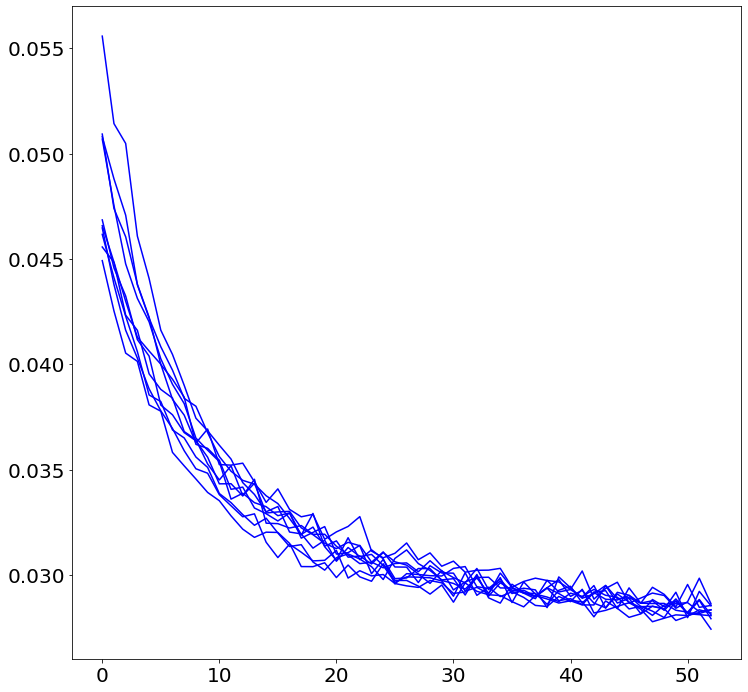

In [0]:
# check how training looked
NNs_hist_train=np.array(NNs_hist_train)
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
for m in range(n_ensemble):
    ax.plot(NNs_hist_train[m][10:-1], color='b',label='train')
fig.show()

In [0]:
# run predictions
y_preds_train, y_preds_mu_train, y_preds_std_train = fn_predict_ensemble(NNs,train_x)
y_preds_test, y_preds_mu_test, y_preds_std_test = fn_predict_ensemble(NNs,test_x)
y_preds_std_train = np.sqrt(np.square(y_preds_std_train) + data_noise)
y_preds_std_test = np.sqrt(np.square(y_preds_std_test) + data_noise)

In [0]:
print('Test RMSE: {}'.format(np.sqrt(np.mean(np.square(y_preds_mu_test.T - test_y)))))
print('Train RMSE: {}'.format(np.sqrt(np.mean(np.square(y_preds_mu_train.T - train_y)))))

Test RMSE: 0.16630754419647087
Train RMSE: 0.129747468180478


Generate attribution plots for a particular input.

In [0]:
attrib_list = []
for i in range(n_ensemble):
  model = NNs[i]
  test_idx = 1150
  xi = test_x[[test_idx]]
  with DeepExplain(session=K.get_session()) as de:  # <-- init DeepExplain context
    # Need to reconstruct the graph in DeepExplain context, using the same weights.
    input_tensors = model.layers[0].input
    fModel = Model(inputs = input_tensors, outputs = model.outputs)
    target_tensor = fModel(input_tensors)

    attributions = de.explain('intgrad', target_tensor, input_tensors, xi)
    attrib_list.append(attributions)

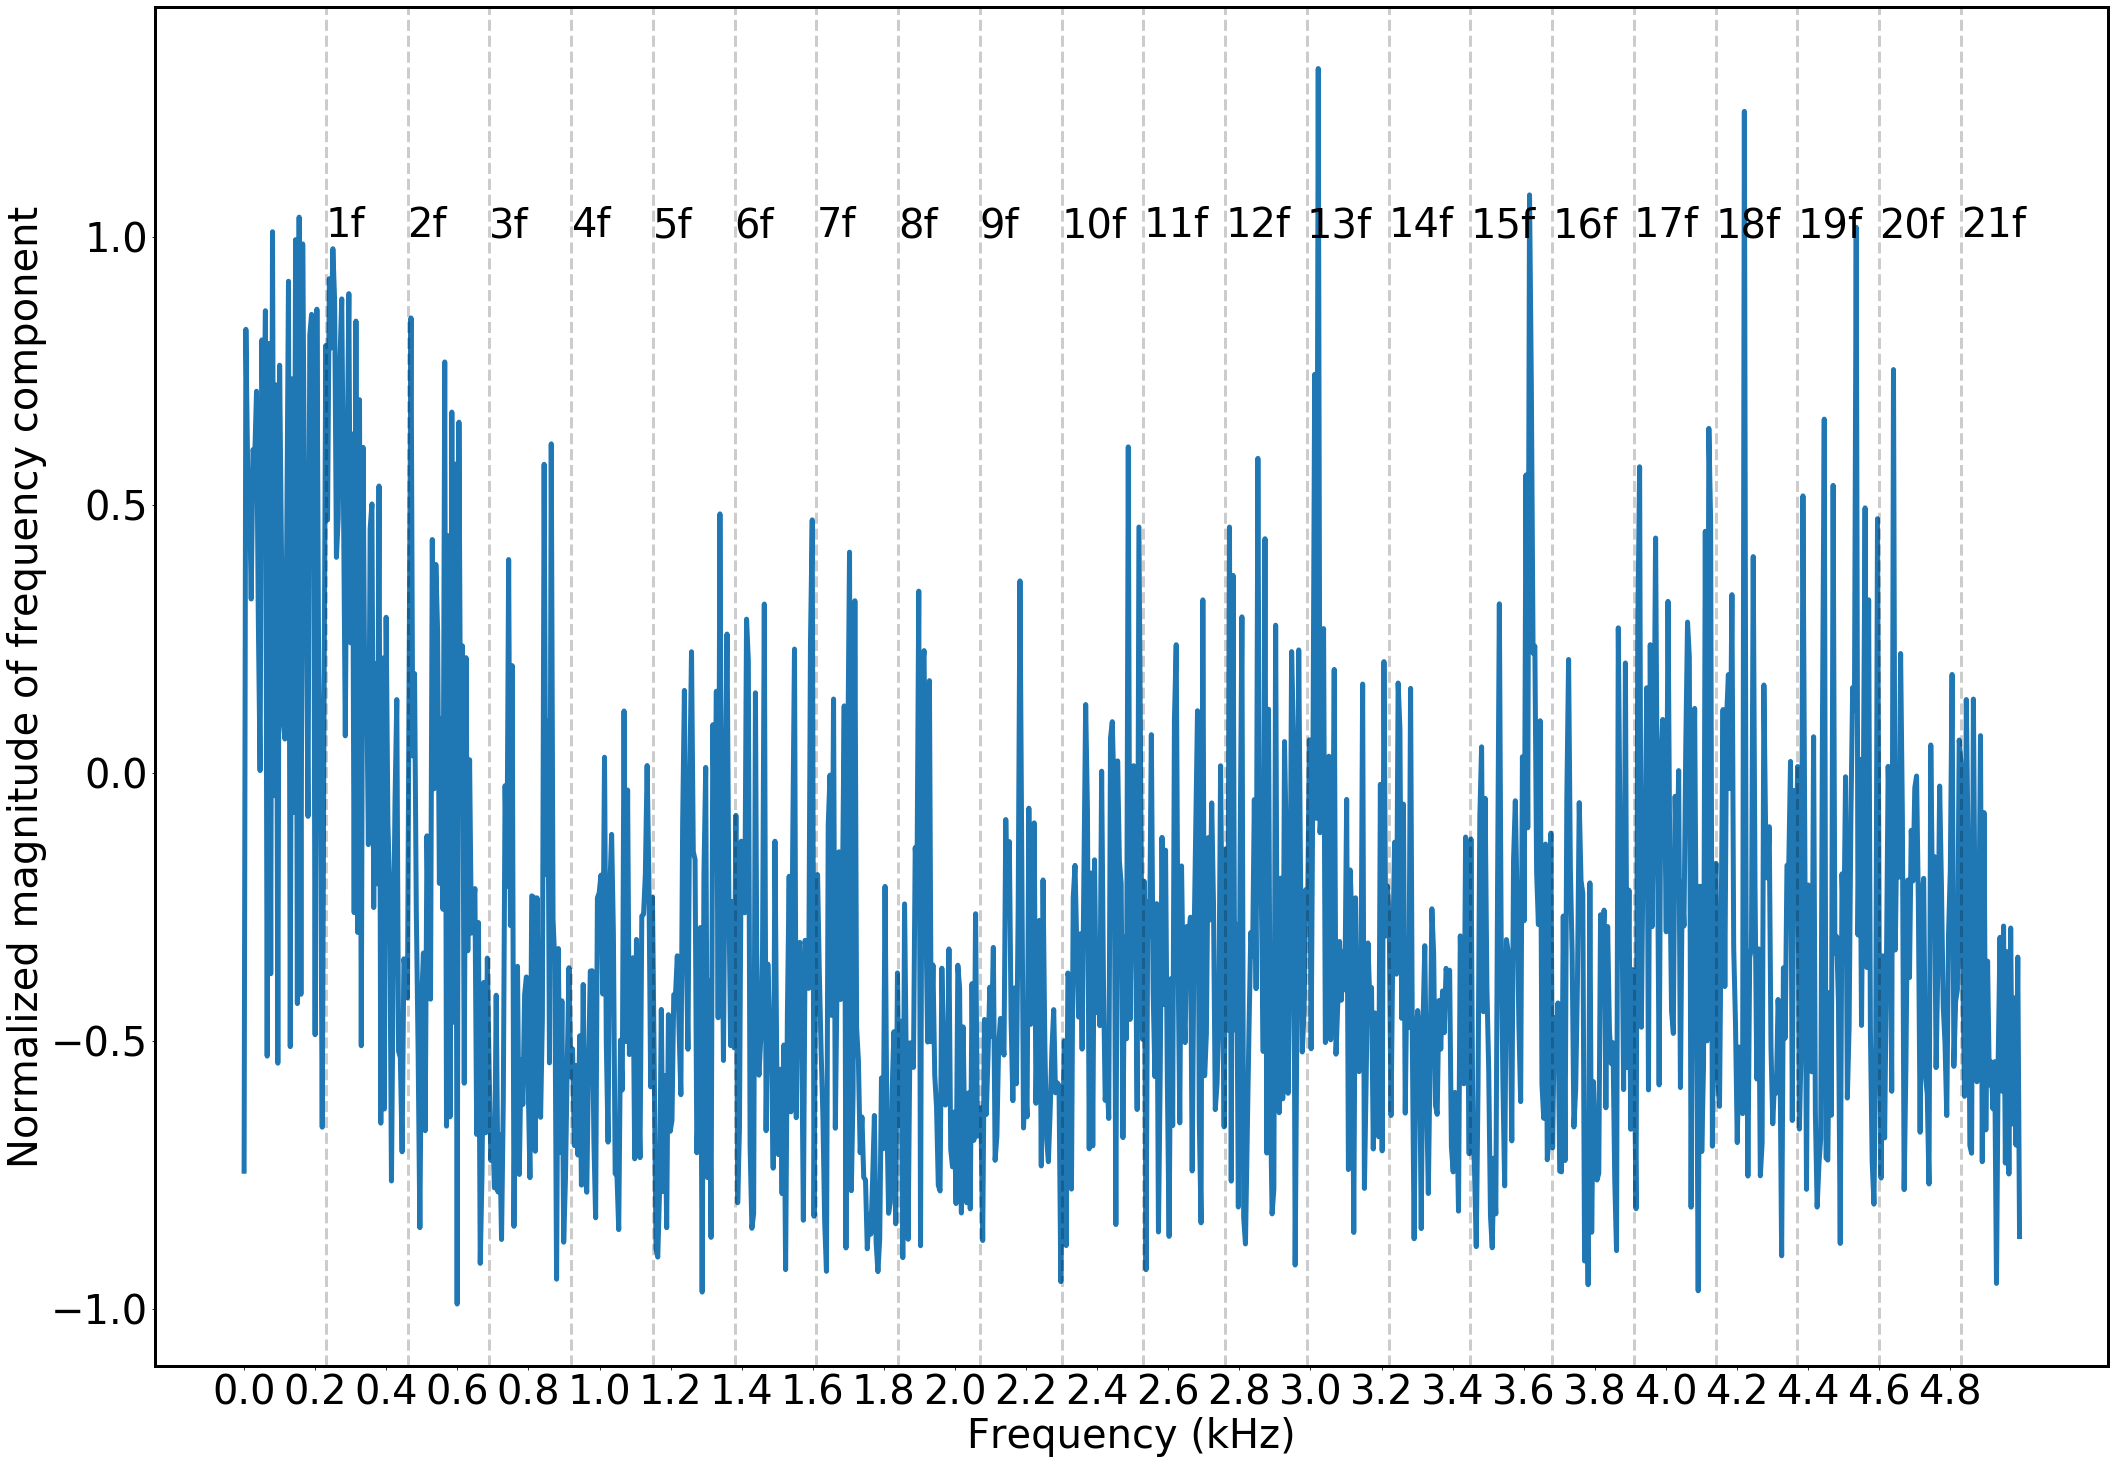

In [0]:
plt.figure(figsize=(35, 25))
plt.rcParams.update({'font.size': 40})
plt.rcParams['axes.linewidth'] = 3
plt.xticks(np.arange(0, 5, step=0.2))
plt.xlabel('Frequency (kHz)')
plt.ylabel('Normalized magnitude of frequency component')
plt.plot(np.arange(1001)*(5000/(1001*1000)),xi[0,:], linewidth=5)
xposition = (np.arange(21)+1)*230/1000
k =  1
for xc in xposition:
    plt.axvline(x=xc, color='k', linestyle='--', linewidth=3, alpha=0.2)
    plt.text(xc, 1, str(k)+'f')
    k = k+1
plt.draw()
plt.savefig('input_spectrum.png', format='png')

0.0911400339987854


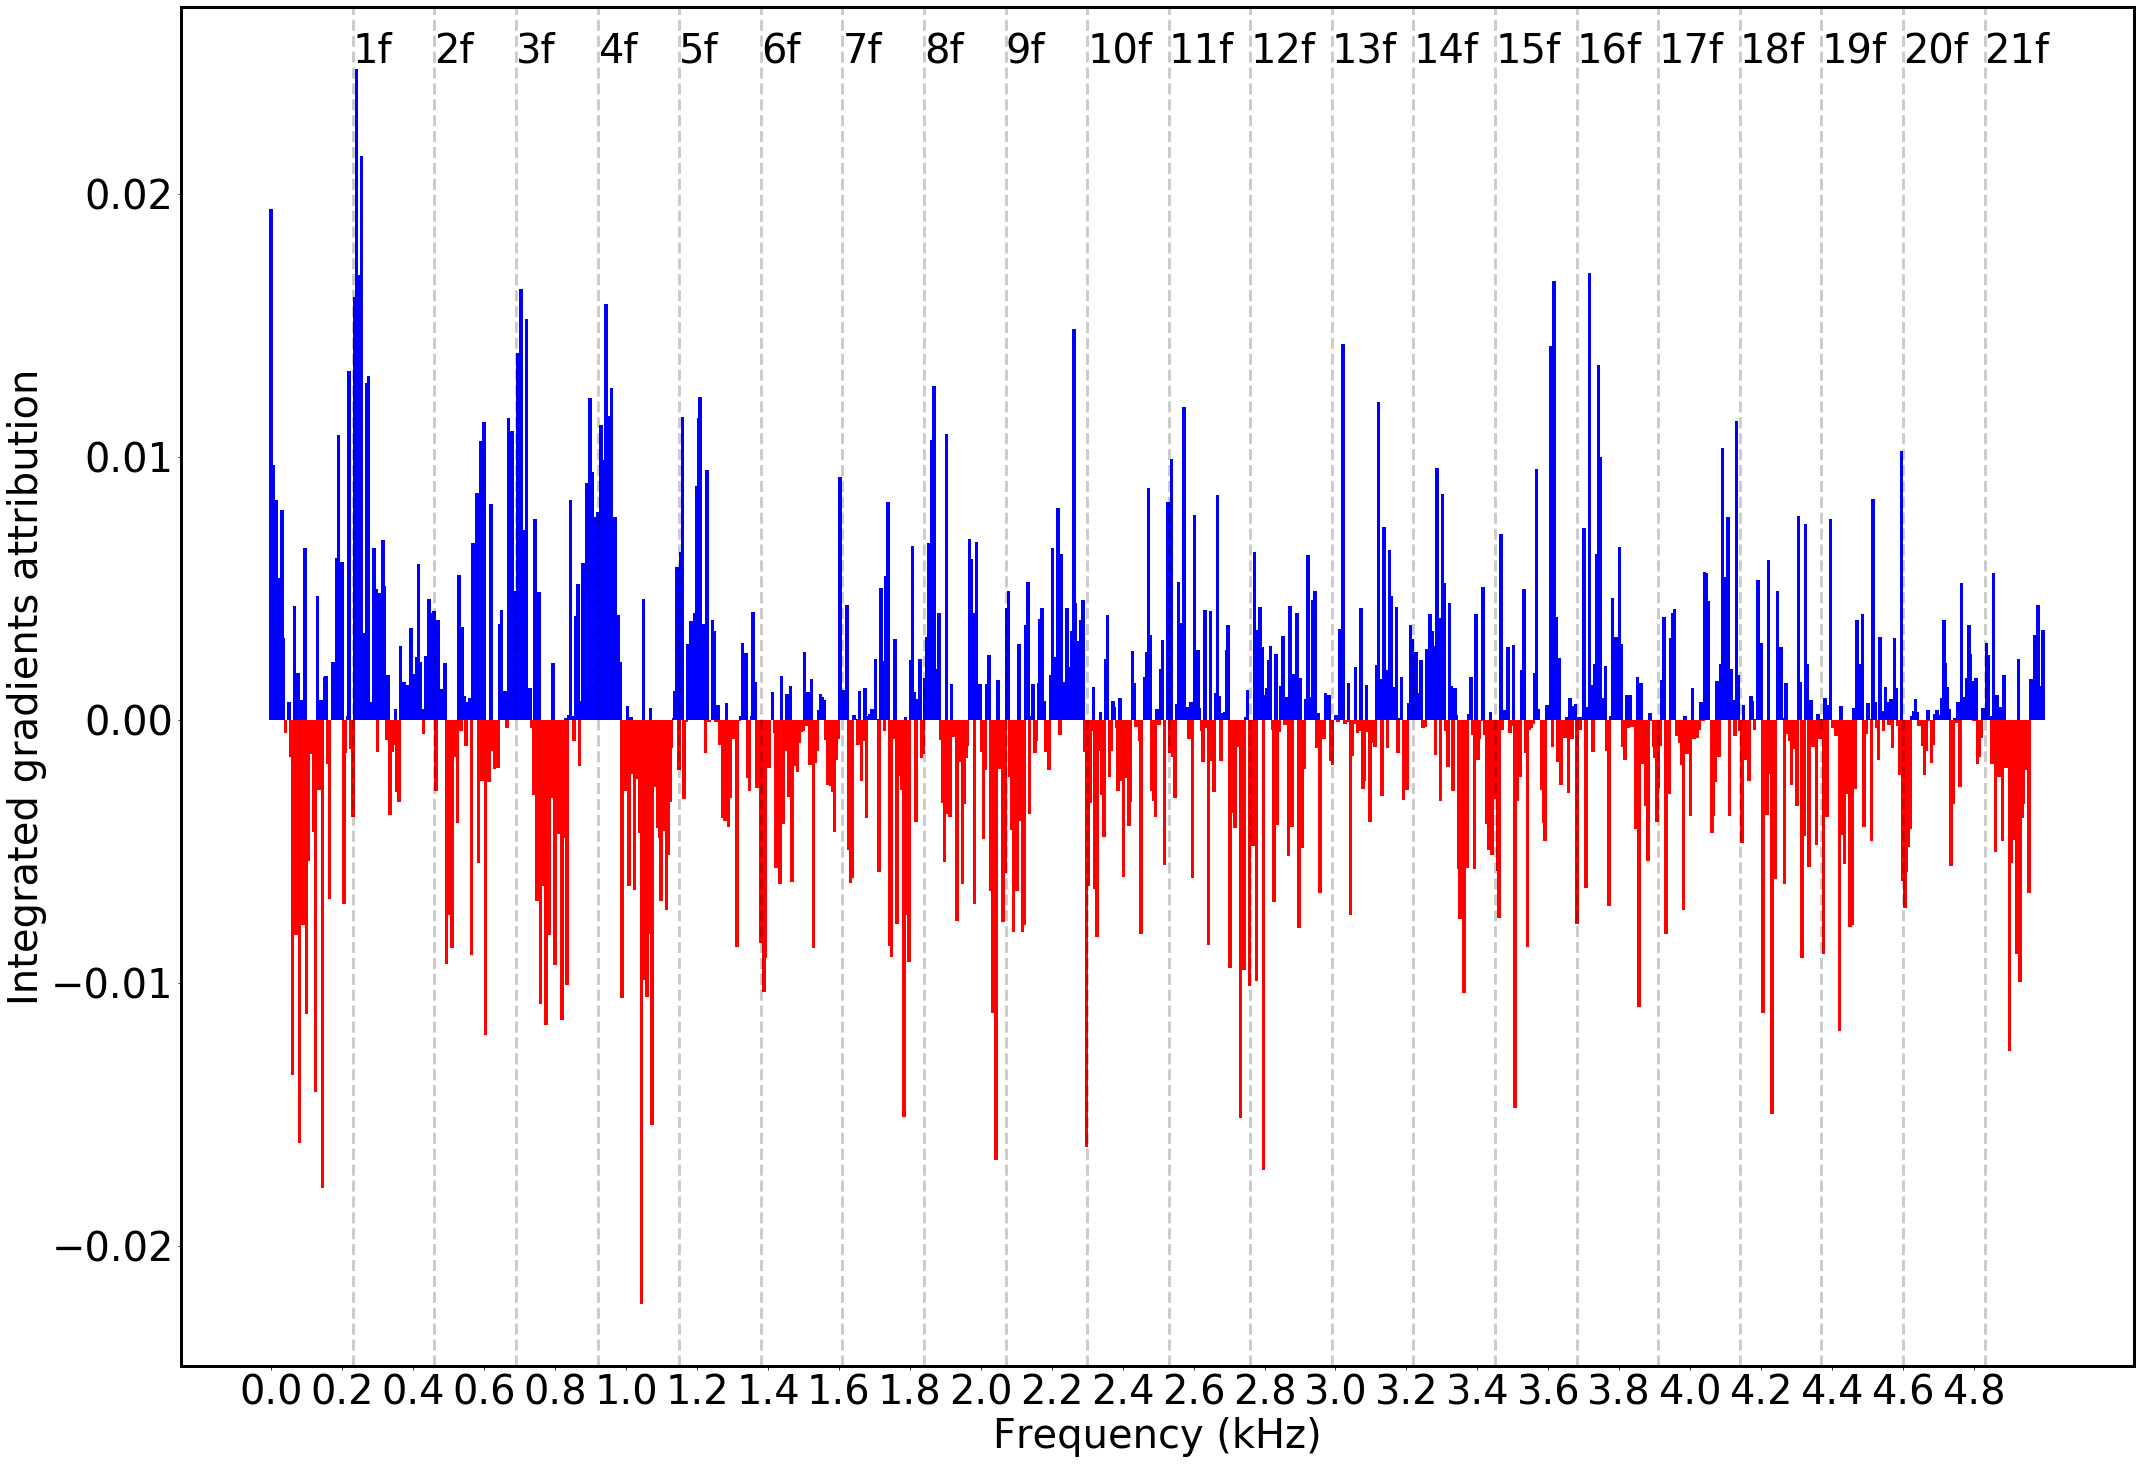

In [0]:
attrib_mean = np.zeros((1,1001))
for i in range(n_ensemble):
  attrib_mean = attrib_mean + attrib_list[i]/n_ensemble

print(np.sum(attrib_mean))
#plt.plot(test_y)
plt.rcParams.update({'font.size': 40})
plt.figure(figsize=(35,25))
plt.xlabel('Frequency (kHz)')
plt.xticks(np.arange(0, 5, step=0.2))
plt.ylabel('Integrated gradients attribution')
color_list = []
for i in range(1001):
  if (attrib_mean[:,i] < 0):
    color_list.append('red')
  else:
    color_list.append('blue')

plt.bar(np.arange(1001)*(5000/(1001*1000)), attrib_mean[0,:], align='center', width = 0.01, color = color_list)
xposition = (np.arange(21)+1)*230/1000
k =  1
for xc in xposition:
    plt.axvline(x=xc, color='k', linestyle='--', linewidth=3, alpha=0.2)
    plt.text(xc, 0.025, str(k)+'f')
    k = k+1
plt.draw()
plt.savefig('integrad.png', format='png')

Compute negative log likelihood of test data given our model. (We want to tune hyperparameters such that this is minimized.)

In [0]:
nll = np.mean(0.5*(((y_preds_mu_test - test_y.T)**2/(y_preds_std_test)**2) + np.log(y_preds_std_test**2) + np.log(2*pi)))
print(nll)

2.1039469505617343


Rescale output data back to original scales.

In [0]:
train_y = (train_y + 1)*((max_decaytime - min_decaytime)/2) + min_decaytime
test_y = (test_y + 1)*((max_decaytime - min_decaytime)/2) + min_decaytime
y_preds_mu_train = (y_preds_mu_train + 1)*((max_decaytime - min_decaytime)/2) + min_decaytime
y_preds_mu_test = (y_preds_mu_test + 1)*((max_decaytime - min_decaytime)/2) + min_decaytime
y_preds_std_train = y_preds_std_train*((max_decaytime - min_decaytime)/2)
y_preds_std_test = y_preds_std_test*((max_decaytime - min_decaytime)/2)

In [0]:
print('Test RMSE: {}'.format(np.sqrt(np.mean(np.square(np.squeeze(y_preds_mu_test) - test_y)))))
print('Train RMSE: {}'.format(np.sqrt(np.mean(np.square(np.squeeze(y_preds_mu_train) - train_y)))))

Test RMSE: 0.03314699522938909
Train RMSE: 0.025860155121579846


Plot measured vs predicted values for the test data. (If the model generalizes well to test data, our data points should be close to the dotted x = y line.) Gray error bars indicate uncertainty in predicted values (1 standard deviation).

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  after removing the cwd from sys.path.


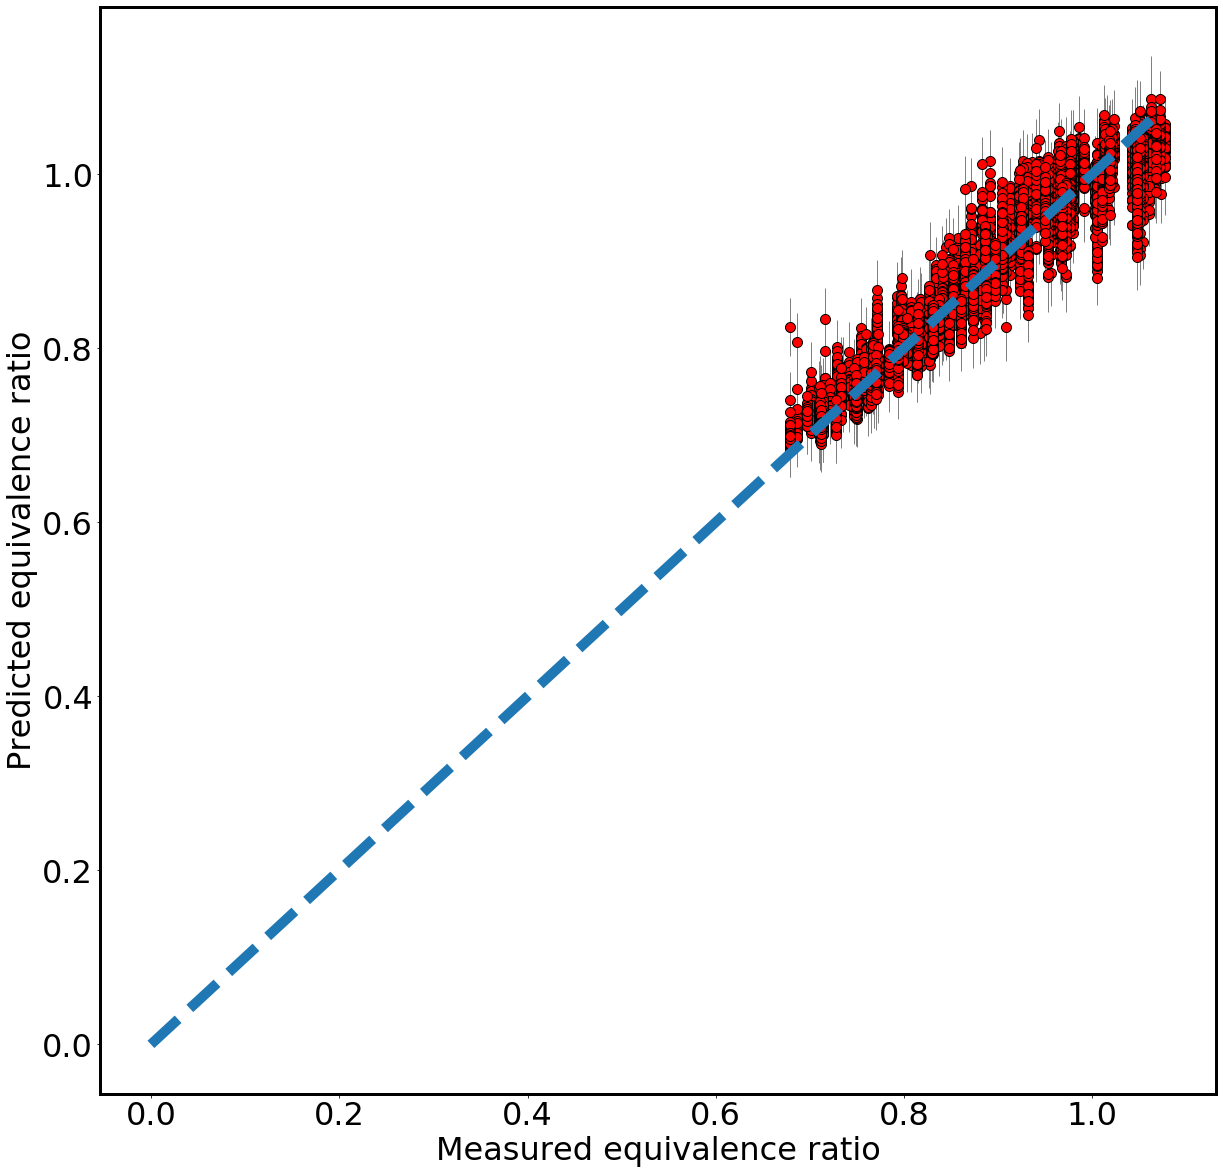

In [0]:

plt.rcParams.update({'font.size': 32})
plt.rcParams['axes.linewidth'] = 3
plt.figure(figsize=(20,20))
plt.errorbar(test_y, y_preds_mu_test, yerr=(y_preds_std_test*1),linewidth = 1.0, color = 'gray', ms=10,mfc='red',mec='black', fmt='o')
plt.plot(np.arange(0, np.max(train_y), 0.01), np.arange(0, np.max(train_y), 0.01), linewidth = 10, linestyle = 'dashed',zorder = 100)
plt.xlabel('Measured equivalence ratio')
plt.ylabel('Predicted equivalence ratio')
plt.draw()
plt.savefig('testperformance.png', format='png')